# High Value Customers Identification

## 0. Importação de Bibliotecas e *Helper Functions*

In [106]:
import warnings
import numpy   as np
import pandas  as pd
import seaborn as sns
from plotly              import express as px
from matplotlib          import pyplot as plt
from sklearn.cluster     import KMeans
from sklearn.metrics     import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [2]:
def personal_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['font.size'] = 20
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x:'%.2f' % x)
    sns.set()
    sns.set(rc = {'figure.figsize':(12,6)})
    warnings.filterwarnings('ignore')

personal_settings()

## 1. Carregando os Dados

In [3]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom,NaN


In [4]:
df_raw = df_raw.drop(columns='Unnamed: 8')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


## 2. Descrição dos Dados

In [47]:
df1 = df_raw.copy()

### 2.1 Renomeando Colunas

In [48]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [49]:
new_cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = new_cols
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

### 2.2 Dicionário de Colunas

|     Coluna    |              Significado              |
| ------------- | ------------------------------------- |
|   invoice_no   | identificador único de cada transação   |
|   stock_code   | código do item                        |
|   description | nome do item                          |
|   quantity    | quantidade de cada item por transação |
|   invoice_date | data da transação                     |
|   unit_price   | preço do item por unidade             |
|   customer_id  | identificador único do cliente        |
|   country     | país em que o cliente reside          |

### 2.3 Dimensões

In [51]:
print(f'Número de linhas/registros: {df1.shape[0]}')
print(f'Número de colunas/atributos: {df1.shape[1]}')

Número de linhas/registros: 541909
Número de colunas/atributos: 8


### 2.4 Tipos de Dados

In [52]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 2.5 Registros Duplicados

In [53]:
df1.duplicated().sum()

5269

### 2.6 Valores Nulos

In [54]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 2.7 Removendo Valores Nulos

In [56]:
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Porcentagem de dados removidos: {:.2f}%'.format((1-(df1.shape[0] / df_raw.shape[0])) * 100))
print(f'Número de registros restantes: {df1.shape[0]}')

Porcentagem de dados removidos: 24.93%
Número de registros restantes: 406829


In [57]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

### 2.8 Alterando Tipos de Dados

#### 2.8.1 *InvoiceDate*

In [58]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')
df1['invoice_date'].head()

0   2016-11-29
1   2016-11-29
2   2016-11-29
3   2016-11-29
4   2016-11-29
Name: invoice_date, dtype: datetime64[ns]

#### 2.8.2 *CustomerID*

In [59]:
df1['customer_id'] = df1['customer_id'].astype('int64')
df1['customer_id'].head()

0    17850
1    17850
2    17850
3    17850
4    17850
Name: customer_id, dtype: int64

### 2.9 Análise Estatística Descritiva

## 3. *Feature Engineering* - Criação de Variáveis

In [60]:
df2 = df1.copy()

### 3.1 Criação de features com base no RFM Model (Recency, Frequency e Monetary)

In [61]:
df2.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

In [62]:
df_ref = df2.drop(columns=['invoice_no', 'stock_code', 'description', 'quantity', 
                           'invoice_date', 'unit_price', 'country']).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


#### 3.1.1 Gross Revenue (Monetary)

Para a métrica monetária, vou adotar o faturamento bruto por cliente.

In [63]:
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

In [64]:
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_monetary.head()

,customer_id,gross_revenue
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


In [65]:
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue
0,17850,5288.63
1,13047,3079.10
2,12583,7187.34
3,13748,948.25
4,15100,635.10


In [66]:
df_ref.isna().sum()

customer_id      0
gross_revenue    0
dtype: int64

#### 3.1.2 Recency

Número de dias desde a última compra feita pelo cliente.

Como último dia para comparação, vou pegar a data da última transação no conjunto de dados.

In [67]:
# Obtendo a data de transação mais recente por cliente
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency.head()

,customer_id,invoice_date
0,12346,2017-01-16
1,12347,2017-12-05
2,12348,2017-09-23
3,12349,2017-11-19
4,12350,2017-01-31


In [68]:
# Calculando o número de dias desde a última transação
df_recency['recency'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency.drop(columns=['invoice_date'])
df_recency.head()

,customer_id,recency
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310


In [69]:
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency
0,17850,5288.63,302
1,13047,3079.10,31
2,12583,7187.34,2
3,13748,948.25,95
4,15100,635.10,330


In [70]:
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency          0
dtype: int64

#### 3.1.3 Frequency

In [71]:
df_frequency = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns= {'invoice_no': 'frequency'})
df_frequency.head()

,customer_id,frequency
0,12346,2
1,12347,7
2,12348,4
3,12349,1
4,12350,1


In [72]:
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency,frequency
0,17850,5288.63,302,35
1,13047,3079.10,31,18
2,12583,7187.34,2,18
3,13748,948.25,95,5
4,15100,635.10,330,6


In [73]:
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency          0
frequency        0
dtype: int64

#### 3.1.4 Average Ticket

In [91]:
df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_avg_ticket.head()

,customer_id,avg_ticket
0,12346,0.00
1,12347,23.68
2,12348,57.98
3,12349,24.08
4,12350,19.67


In [92]:
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.head()

,customer_id,gross_revenue,recency,frequency,avg_ticket
0,17850,5288.63,302,35,16.95
1,13047,3079.10,31,18,15.71
2,12583,7187.34,2,18,28.63
3,13748,948.25,95,5,33.87
4,15100,635.10,330,6,105.85


In [93]:
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency          0
frequency        0
avg_ticket       0
dtype: int64

## 4. Filtragem de Variáveis

In [117]:
df3 = df_ref.copy()

## 5. Análise Exploratória de Dados

In [118]:
df4 = df3.copy()

## 6. Preparação dos Dados

In [119]:
df5 = df4.copy()

## 7. *Feature Selection* - Seleção de Variáveis

In [120]:
df6 = df5.copy()

## 8. *Hyperparemeter Fine Tunning* - Encontrando o Melhor Número de Clusters

Para encontrar o melhor valor de clusters, vou usar do algoritmo *KMeans*, e comparar a performance de acordo com métricas de *Compactness* e *Separation*.

In [121]:
X = df6.drop(columns=['customer_id'])
X.head()

,gross_revenue,recency,frequency,avg_ticket
0,5288.63,302,35,16.95
1,3079.10,31,18,15.71
2,7187.34,2,18,28.63
3,948.25,95,5,33.87
4,635.10,330,6,105.85


In [122]:
n_clusters = [2, 3, 4, 5, 6, 7]

### 8.1 WCSS (*Within-Cluster Sum of Square*)

A métrica usada para verificar a *Compactness* dos clusters vai ser o WCSS (*Within-Cluster Sum of Square*) 

Para verificar essa métrica para diferentes números de clusters, vou usar do método do Cotovelo (*Elbow Method*).

De acordo com esse método, o melhor valor de clusters vai ser aquele que apresenta a maior diferença/variação em comparação com o próximo valor (o cotovelo no gráfico).

Para facilitar, a função *KElbowVisualizer* já indica qual o melhor valor para o número de clusters no gráfico.

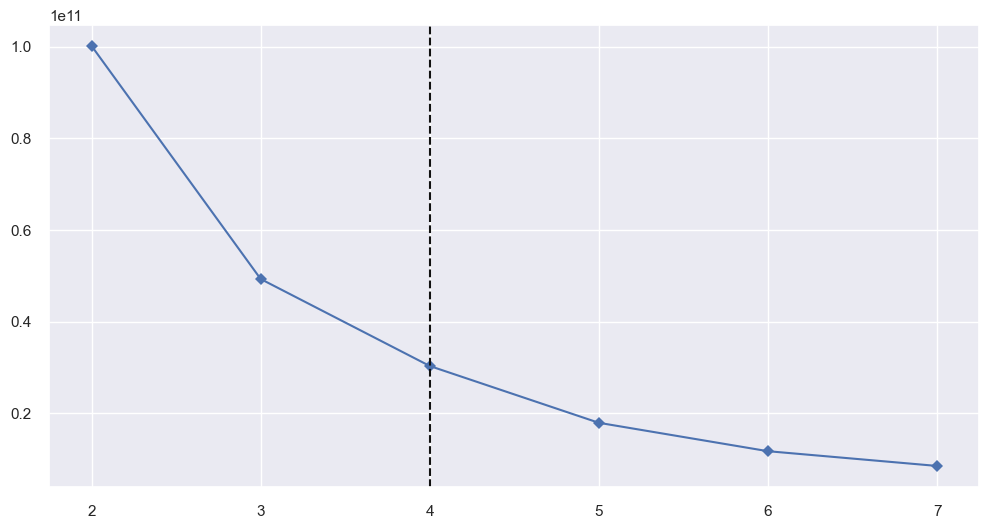

In [123]:
kmeans = KElbowVisualizer(KMeans(), k=n_clusters, timings=False)
kmeans.fit(X)
kmeans.show;

De acordo com a WCSS, o melhor número de clusters é 3. 

### 8.2 SS (*Silhouette Score*)

A métrica usada para verificar a *Separation* dos clusters vai ser a *Silhouette Score*

Para verificar essa métrica para diferentes números de clusters, também vou usar da função *KElbowVisualizer*, mas passando como parâmetro a métrica *silhouette*.

De acordo com essa métrica, o melhor valor para o número de clusters vai ser aquele que apresentar uma *Silhouette Score* mais próxima de 1. 

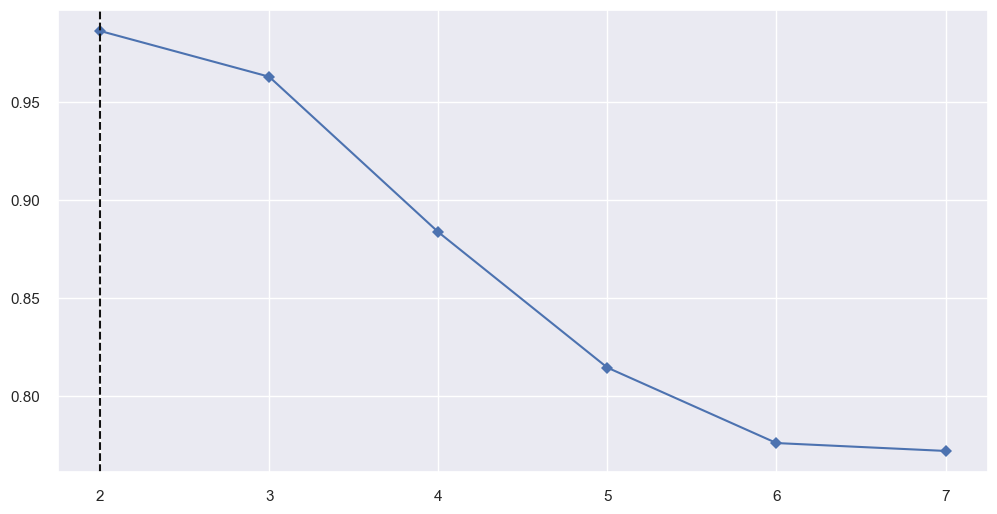

In [124]:
kmeans = KElbowVisualizer(KMeans(), k=n_clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show;

De acordo com a SS, o melhor número de clusters é 2, mas podemos ver que 3 clusters não apresentam uma performance muito pior. 

Assim, vou seguir com 3 clusters para o conjunto de dados.

### 8.3 *Silhouette Analysis*

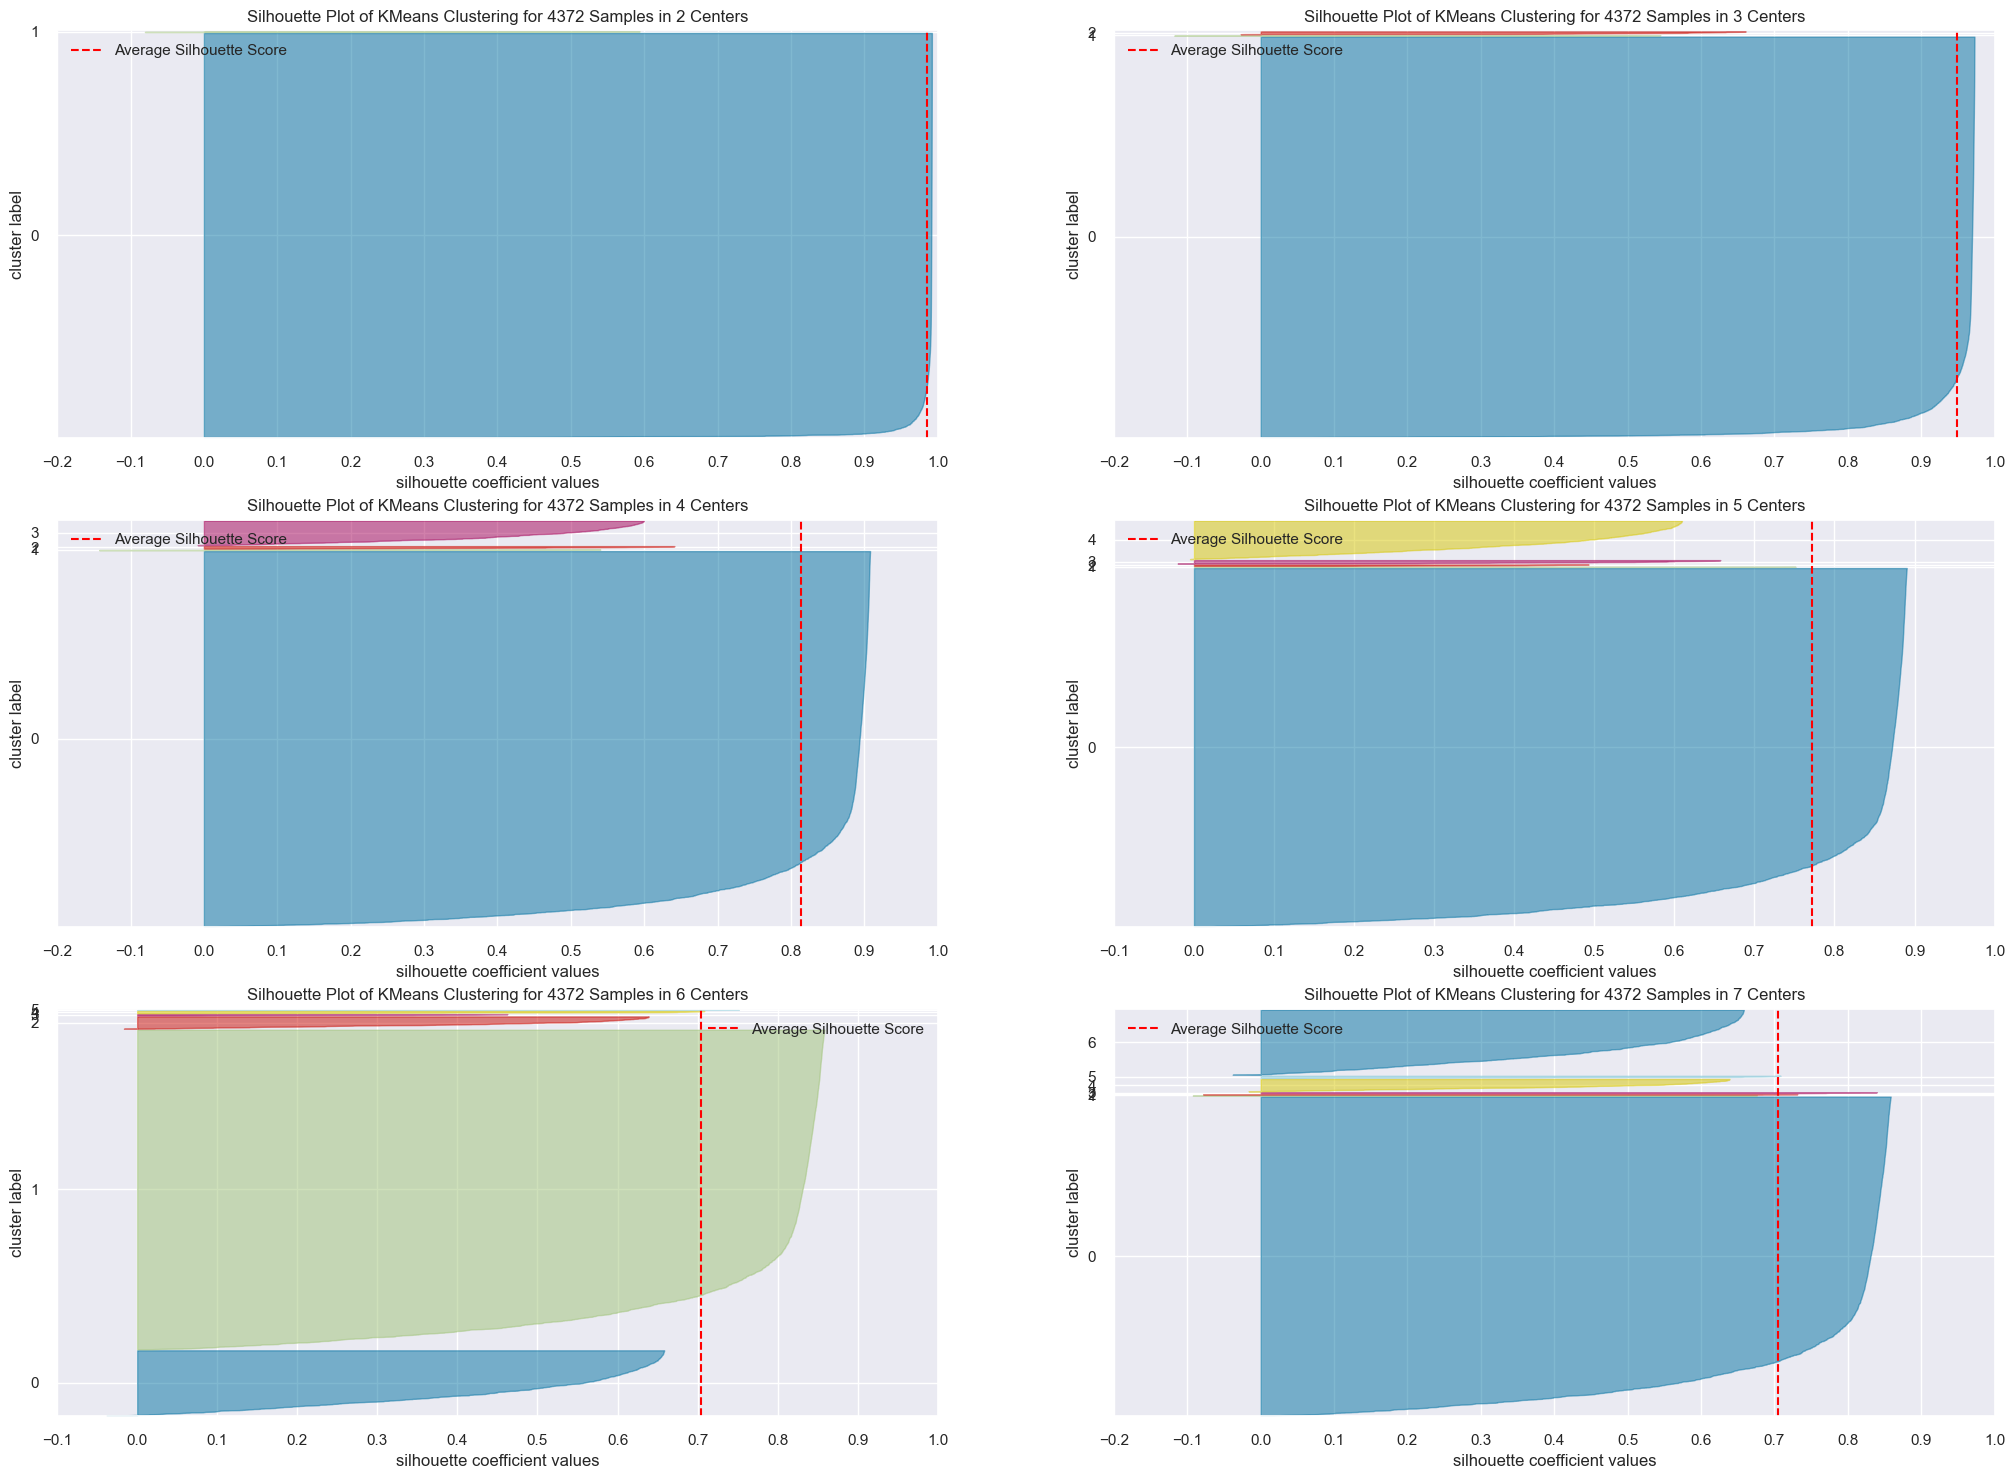

In [125]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))

for k in n_clusters:
  km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
  q, mod = divmod(k, 2)
  visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
  visualizer.fit(X)
  visualizer.finalize()

## 9. *Machine Learning*

### 9.1 *KMeans*

In [126]:
# Modelo
k = 3
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# Treinamento
kmeans.fit(X)

# Clustering
labels = kmeans.labels_

#### 9.1.2 *Cluster Validation*

In [127]:
# WSS
print('WSS: {:.2f}'.format(kmeans.inertia_))
# SS
print('SS: {:.2f}'.format(silhouette_score(X, labels, metric='euclidean')))

WSS: 52900059994.70
SS: 0.95


## 10. *Cluster Analysis*

In [128]:
df7 = df6.copy()
df7['cluster'] = labels
df7.head()

,customer_id,gross_revenue,recency,frequency,avg_ticket,cluster
0,17850,5288.63,302,35,16.95,0
1,13047,3079.10,31,18,15.71,0
2,12583,7187.34,2,18,28.63,0
3,13748,948.25,95,5,33.87,0
4,15100,635.10,330,6,105.85,0


### 10.1 *Visual Inspection*

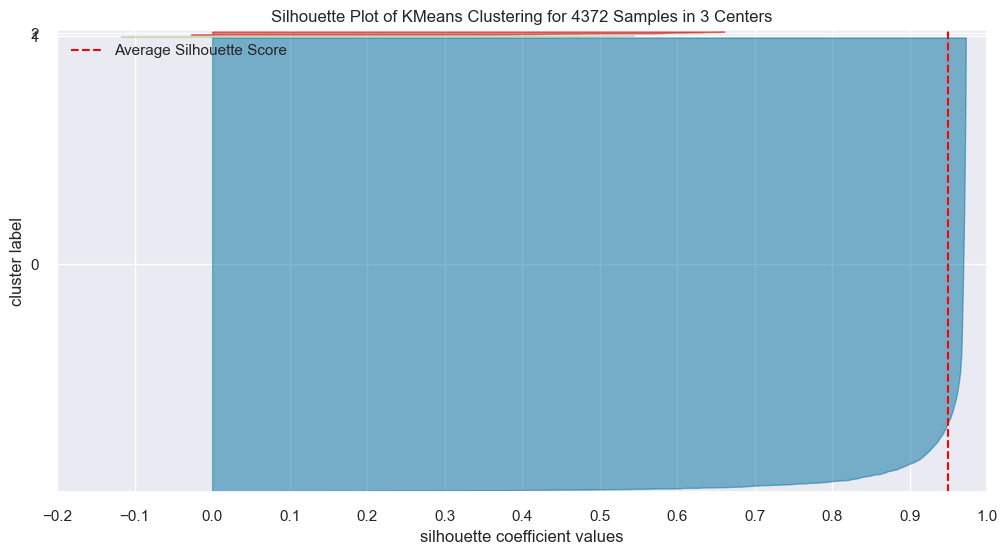

In [129]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

### 10.2 *2D Plot*

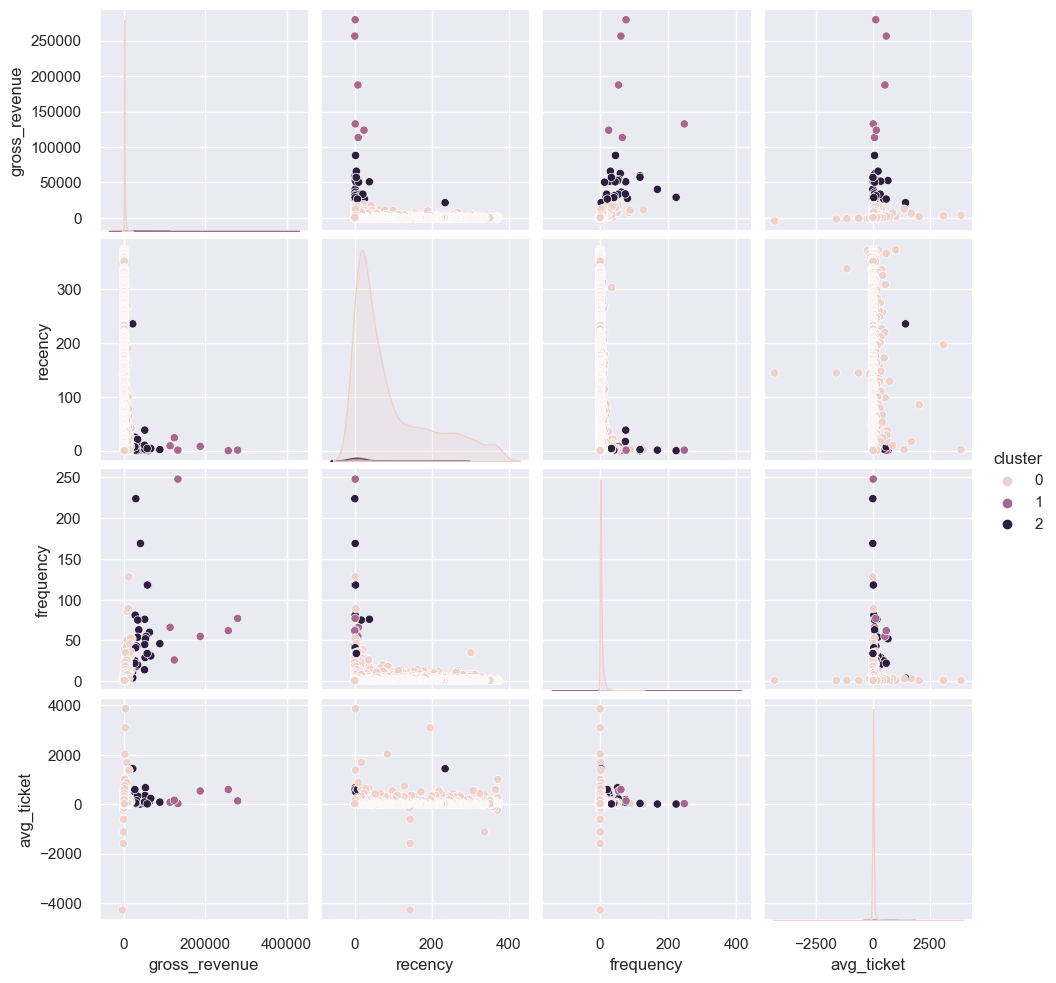

In [130]:
df_viz = df7.drop(columns='customer_id')
sns.pairplot(df_viz, hue='cluster');

### 10.3 *UMAP*

### 10.4 *Cluster Profile*

In [86]:
# Número de clientes por cluster
df_cluster = df7[['customer_id', 'cluster']].groupby('cluster').count().reset_index()

# Porcentagem em relação ao total de clientes
df_cluster['percentage'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

In [87]:
# Média de GrossRevenue por cluster
df_avg_revenue = df7[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_revenue, how='inner', on='cluster')

In [88]:
# Média de RecencyDays por cluster
df_avg_recency = df7[['recency', 'cluster']].groupby('cluster').mean().round().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, how='inner', on='cluster')

In [89]:
# Média de Frequency por cluster
df_avg_frequency = df7[['frequency', 'cluster']].groupby('cluster').mean().round().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, how='inner', on='cluster')

In [90]:
df_cluster

,cluster,customer_id,percentage,gross_revenue,recency,frequency
0,0,4335,99.15,1372.58,92.00,5.00
1,1,6,0.14,182181.98,7.00,89.00
2,2,31,0.71,40543.52,13.00,53.00


#### Cluster 1
- 6 Clientes (0.14% da base total)
- 7 dias de recência média
- 89 compras em média
- Aproximadamente 182.000 em receita em média

#### Cluster 2
- 31 Clientes (0.71% da base total)
- 13 dias de recência média
- 13 compras em média
- Aproximadamente 40.000 em receita em média

#### Cluster 0 
- 4335 clientes (99.15% da base total)
- 92 dias de recência média
- 5 compras em média
- Aproximadamente 1.300 de receita em média

## 11. Modelo em Produção